Pedro Martelleto e João Marcos Cardoso da Silva

# Word Embeddings com a fatoração da matriz de Informação Mútua

Nos últimos anos, o campo de Processamento de Linguagem natural com o Aprendizado de Máquina tem se desenvolvido rapidamente. Os novos modelos são capazes de aprender padrões muito mais complexos que os métodos clássicos do campo, que dependiam de features construídas à mão e sequências de operações bem definidas pelo programador.

Porém, para o bom funcionamento desses modelos, especialmente os de Deep Learning, como as Redes Neurais Recorrentes e os Transformers, é necessário que os textos sejam de alguma forma convertidos do seu espaço discreto a vetores densos. Dessa forma, permite-se o processamento dessas palavras por redes neurais, as quais trabalham por meio de operações aprendidas em espaços vetoriais densos de alta dimensão.

Para esse propósito, é muito comum na literatura do campo o uso da técnica do word2vec, que por meio de um processo iterativo de otimização cria um vetor denso associado a cada palavra, contendo em suas muitas dimensões o significado correspondente àquele termo. Contudo, como foi mostrado [nesse artigo](https://papers.nips.cc/paper/2014/hash/feab05aa91085b7a8012516bc3533958-Abstract.html), o word2vec é equivalente a uma fatoração da matriz de Informação Mútua Pontual, fato que é, em grande parte, responsável pelo seu funcionamento.

## A Informação Mútua Pontual

A utilização da informação mútua pontual entre palavras para a construção do embedding é motivada pela chamada Hipótese Distribucional, que diz que o significado de uma palavra é definido pela distribuição das palavras contidas ao seu redor. Esse fato é resumido pela frase "a word is characterized by the company it keeps", de John Rupert Firth. Por esse motivo, é motivada a utilização dessa métrica para a construção dos embeddings, a qual é descrita a seguir.

Assim, sejam W e C duas palavras distintas. Suponha que as suas frequências no corpus analisado são, respectivamente, P(W) e P(C). Seja também definida a probabilidade P(W, C), que corresponde à frequência na qual ambas as palavras ocorrem em um mesmo contexto (por exemplo, na mesma frase ou dentro de uma janela de 5 palavras).

Fica então definida a Informação Mútua Pontual (PMI) entre W e C:

$$\text{PMI}(W, C) = \log{\left[\frac{P(W,C)}{P(W)P(C)}\right]}$$

Essa medida tem as seguintes propriedades:
 
 - PMI(W, C) = 0 se e somente se as palavras W e C são independentes entre si (ou seja, a ocorrência de uma não afeta a chance da segunda ocorrer).
 - PMI(W, C) > 0 se e somente se a observação de W aumenta a probabilidade de observarmos C, ou vice-versa. Quanto maior esse valor, mais frequentemente as duas palavras aparecem no mesmo contexto.
 - PMI(W, C) < 0 se e somente se a observação de W diminui a probabilidade de observarmos C, ou vice-versa. Quanto menor esse número, mais raramente as duas palavras aparecem no mesmo contexto.
 
No sentido da Teoria da Informação, a função PMI mede exatamente a Quantidade de Informação (em bits, caso o logaritmo seja na base 2) que uma observação a respeito de W nos dá sobre a distribuição de C, ou vice-versa.

Como os valores de P(W), P(C) e principalmente P(W,C) não são conhecidos, mas sim estimados a partir de um conjunto de dados finito, valores negativos para a PMI (que indicam palavras que ocorrem pouco) são frequentemente mais ruidosos que os valores positivos. Por esse motivo, dentre outros, é mais comum na literatura utilizar a função PPMI, que substitui valores negativos por 0:

$$\text{PPMI}(W, C) = \max(0, \text{PMI}(W, C))$$

Assim, podemos construir a chamada matriz PPMI, de dimensão N por N, onde N é o número de palavras no vocabulário estudado, e cada uma das suas entradas, de índices (i,j) contém o valor relativo à $\text{PPMI}(W_i, W_j)$, onde $W_i$ e $W_j$ são as palavras correspondentes à linha $i$ e coluna $j$ da matriz. Essa matriz contém então informação a respeito da distribuição de todos os pares de palavras no conjunto de dados, podendo ser utilizada para a geração de embeddings para os termos que representem bem os significados dos mesmos.

# A Fatoração Aproximada

A matriz PPMI, apesar de muitas vantagens teóricas, é extremamente grande. De fato, ela possui um número de elementos igual ao quadrado do tamanho do vocabulário. Logo, não é ideal trabalhar com a mesma, tanto por motivos de eficiência computacional, uso de memória e mesmo precisão das estimações feitas a partir do dataset finito. Além disso, podemos pensar nesse problema em termos de tamanho da matriz na memória. Se temos 10^6 palavras no vocabulário (o que não é incomum), teremos 10^12 entradas na matriz PPMI. Isto é, assumindo o uso de float32, a matriz terá tamanho de $2 * 10^12$ bytes (2 terabytes). Não é necessário muito detalhamento para entender que esse fato torna inviável a utilização da PPMI sem nenhuma outra medida.

Para resolver esse problema, fazemos duas mudanças. A primeira é fatorar a matriz para que ela tenha um rank menor. Isso aumentará a eficiência dos nossos embeddings (guardados por menos números), diminuindo a esparsidade, e mantendo somente as características mais importantes:

$$M_\text{PPMI} \approx W \cdot V^T$$

$W$ e $V$ são matrizes $N$ por $d$, com $d < N$.

A segunda medida adotada é usar uma representação esparsa da matriz na memória, otimizando o número grande de 0's presentes na matriz.

É conhecido da literatura que métodos iterativos como o word2vec e o GloVe estão implicitamente realizando uma fatoração análoga a esta, com os embeddings finais sendo as linhas da matriz $W$ (embora não na matriz PPMI, mas em uma relacionada). Contudo, nesse trabalho, faremos essa fatoração diretamente a partir da matriz, utilizando o SVD.

## SVD

A técnica SVD é uma generalização da decomposição em autovetores e autovalores que também pode ser extendida a matriz singulares ou não quadradas. No nosso caso, a matriz $M_{PPMI}$ é fatorada da seguinte forma:

$$M_\text{PPMI} = U \Sigma V^T$$

$U$ e $V$ são matrizes ortogonais e $\Sigma$ é uma matriz diagonal contendo os Valores Singulares.

É possível usar o SVD para criar uma fatoração aproximada da matriz em rank menor, se usarmos somende os $d$ maiores valores singulares e as respectivas linhas e colunas nas matrizes ortogonais:

$$M_\text{PPMI} = U' \Sigma' V'^T$$

$\Sigma'$ é uma matriz quadrada $d$ por $d$ e $U'$ e $V'$ são matrizes $N$ por $d$, como descrito acima.

Assim, se definirmos $W = U' \Sigma'$, recuperamos a matriz dos embeddings como descrito na seção anterior.

Por motivos computacionais, já que a matriz PPMI é armazenada de forma esparsa, foi utilizada uma variação do algoritmo do SVD que calcula uma aproximação estocástica dessa fatoração.

## Regressão Logística

Como um exemplo da aplicação desses embeddings, iremos treinar um modelo de regressão logística para detectar o sentimento a partir de um tweet em português (se Positivo ou Negativo).

Para isso, criamos um único vetor $x$ para representar cada tweet, o qual é composto pela média dos embeddings de cada palavra que compõe o texto. Como as dimensões dos vetores possuem significado semântico e estão no mesmo espaço vetorial, a sua média pode, de certa forma, representar o conteúdo da frase.

Em seguida, definimos um vetor de pesos $\textbf{w}$, cujos parâmetros são considerados treináveis. Ou seja, serão otimizados para o nosso problema. Seja $X$ a matriz cujas linhas são os vetores $x$ para cada tweet do dataset. Temos então a seguinte função, que faz as predições dos valores de $y$ a partir dos parâmetros:

$$\hat{Y} = \sigma(X \textbf{w})$$

onde função logística $\sigma(x) = \frac{1}{1 + e^{-x}}$ é aplicada elemento a elemento. A função logística tem a propriedade de que todos os valores da sua saída estão contidos entre 0 e 1.

Assim, definimos o valor "esperado" de $Y$ como sendo 1 para frases de sentimento "Positivo" e 0 para frases de sentimento "Negativo". Nosso objetivo então é encontrar os valores de $w$ que levem a predições $\hat{Y}$ próximas do valor esperado $Y$. Podemos fazer isso minimizando a seguinte função de custo, chamada de entropia cruzada binária (sua definição e motivação vêm da Teoria da Informação, mas para os propósitos desse trabalho basta dizer que ela é minimizada quanto o preditor possui 100% de acurácia):

$$L(\textbf{w}) = - \left[ Y \cdot (\log \hat{Y}) + (1- Y) \cdot (\log(1 - \hat{Y}))\right]$$

Na equação acima, subtrações e a aplicação logaritmo são feitas elemento a elemento e as multiplicações são produtos escalares.

### Otimização

Podemos encontrar os melhores valores para $\textbf{w}$ utilizando o método do Gradiente Descendente, que consiste em fazer a seguinte atualização repetidas vezes, onde $\alpha$ é um número real pequeno chamado de taxa de aprendizado:

$$\textbf{w} \leftarrow \textbf{w} - \alpha [\nabla L(\textbf{w})]^T$$

Assim, é necessário calcular o gradiente (aqui usamos vetores linha como gradientes) da função de custo em função de $\textbf{w}$:

$$\nabla L(\textbf{w}) = \left(\hat{Y}^T - Y^T\right)X$$

## Prática

### Imports usados no código

In [10]:
# install datasets
!pip3 install datasets unidecode ipywidgets tqdm --quiet

import os
from datasets import load_dataset
from pprint import pprint
from tqdm import tqdm
import numpy as np
from unidecode import unidecode
import re
import scipy.sparse
import scipy
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from cb91visuals import *

dim = 128

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


### Dataset

In [11]:
dataset = load_dataset('capes')
dataset['train']['translation'][0:5]

Reusing dataset capes (/home/Pedro/.cache/huggingface/datasets/capes/en-pt/1.0.0/b2c08eed67d23b54883a184eb830ecc54bc1cb7f7e4527ee45586ef5bbd0cc8f)


  0%|          | 0/1 [00:00<?, ?it/s]

[{'en': 'in this thesis we present two distinct research lines, namely, the first, referring to chapters 2 and 3, apply statistical techniques to the analysis of synthetic aperture radar (sar) images, and the second, referring to chapter 4, we examined problems concerning parameter estimation by maximum likelihood in exponential-poisson distribution.',
  'pt': 'nessa tese apresentamos duas linhas de pesquisa distintas, a saber, na primeira, referente aos capítulos 1 e 3 aplicamos técnicas estatísticas à análise de imagens do satélite de abertura sintética (sar) e, na segunda, referente ao capítulo 2, examinamos problemas relativos à estimação de parâmetros por máxima verossimilhança na distribuição exponencial-poisson.'},
 {'en': 'in chapter 2 we study the problem of estimating edges in sar images, which by nature are fraught with multiplicative noise, also known as speckle.',
  'pt': 'no capítulo 1 estudamos o problema de estimação de bordas em imagens sar.'},
 {'en': 'this noise lead

### Aqui, fazemos o processamento do dataset para construir a PPMI

In [12]:
pprint(dataset)

texts = []

# Removes punctuation and numbers from the text
print("Pre-processing dataset...")
def process_text(text):
  txt = unidecode(text).replace('\n' , '') # Normalizes string
  txt = re.sub(r"\([^()]*\)", "", txt) # Removes everything inside parenthesis
  txt = re.sub(r'\w*\d\w*', ' ', txt).strip() # Remove numbers
  txt = re.sub(r'[^a-zA-Z0-9]', ' ', txt) # Removes all non-alphanumeric characters
  txt = re.sub(r"\s{2,}", ' ', txt).strip() # Removes double or more spaces
  return txt

# Processes the dataset
for text in tqdm(dataset['train']['translation']):
  texts.append(process_text(text['pt']))

MAX_WORD_SIZE = 28
MIN_FREQ = 70

# Helper function that iterates over the dataset
def iterate_dataset(window_size, word_fn, *args):
  for text in tqdm(texts):
    words = text.split(" ")
    for i in range(len(words)):
      word = words[i]

      if len(word) > MAX_WORD_SIZE:
        continue

      for j in range(-window_size, window_size):
        if j + i >= 0 and j + i < len(words):
          if not word_fn is None and len(words[j+i]) <= MAX_WORD_SIZE:
            word_fn(word, words[j + i], *args)

window_size = 2

# Counts the frequency of each word
def word_map_create_fn(word, context, words_map, words_count):
  if not word in words_map:
    words_map[word] = len(words_map)
    words_count[word] = 0
  
  words_count[word] += 1

words_map = {}
words_count = {}

# First, we iterate over the dataset to assign each word to an index
print("Creating word map...")
iterate_dataset(window_size,
                word_map_create_fn,
                words_map, words_count)

# Loads cache if the file exists
if os.path.exists('capes_ppmi.npz'):
  print("Loading ppmi matrix from disk...")
  sparse_ppmi = scipy.sparse.load_npz('capes_ppmi.npz')
# Otherwise, we compute the PPMI matrix
else:
  # Counts the frequency of each word in context
  def freq_ctx_fn(word, context, words_map, freq_matrix):
    if word in words_map and context in words_map:
      freq_matrix[words_map[word], words_map[context]] += 1

  # Creates the frequency matrix
  def create_freq_matrix(window_size):
    words_map = {}
    words_count = {}

    # First, we iterate over the dataset to assign each word to an index
    print("Creating word map...")
    iterate_dataset(window_size,
                    word_map_create_fn,
                    words_map, words_count)
    
    # Remove words that are not frequent enough
    for word, freq in words_count.items():
      if freq < MIN_FREQ:
        if word in words_map:
          del words_map[word]

    # Adjusts the word map indices
    words = []
    i = 0
    for w in words_map:
      words_map[w] = i
      words.append(w)
      i += 1

    print("Vocab size:", len(words_map))
    
    # Creates the frequency matrix
    print("Allocating frequency matrix: {:.2f} GB".format((len(words_map) * len(words_map)) * 2 / (1000 ** 3)))
    freq_matrix = np.zeros((len(words_map), len(words_map)), dtype=np.float32)

    print("Creating frequency matrix...")
    iterate_dataset(window_size, freq_ctx_fn, words_map, freq_matrix)
    return freq_matrix, words

  freq_matrix, words = create_freq_matrix(window_size=2)
  
  # Normalizes the frequency matrix and computes log information
  def create_ppmi_matrix(freq_matrix, positive=True):
    total = freq_matrix.sum()
    word_counts = np.sum(freq_matrix, axis=1)
    context_counts = np.sum(freq_matrix, axis=0)

    expected = np.outer(word_counts, context_counts) / total
    freq_matrix = freq_matrix / expected

    with np.errstate(divide='ignore'):
      freq_matrix = np.log(freq_matrix)

    freq_matrix[np.isinf(freq_matrix)] = 0.0

    if positive:
      freq_matrix[freq_matrix < 0] = 0.0

    return freq_matrix

  ppmi = create_ppmi_matrix(freq_matrix)
  sparse_ppmi = scipy.sparse.coo_matrix(ppmi)
  scipy.sparse.save_npz('capes_ppmi.npz', sparse_ppmi)

{'train': Dataset({
    features: ['translation'],
    num_rows: 1157610
})}
Pre-processing dataset...


100%|██████████| 1157610/1157610 [01:42<00:00, 11341.20it/s]


Creating word map...


100%|██████████| 1157610/1157610 [01:25<00:00, 13610.59it/s]


Loading ppmi matrix from disk...


### SVD Randomizado

In [13]:
import numpy as np
from sklearn.utils.extmath import randomized_svd

# Computes the randomized SVD of the PPMI matrix (useful for sparse matrices)
U, Sigma, VT = randomized_svd(sparse_ppmi, 
                              n_components=dim,
                              n_iter=8,
                              random_state=None)

### Calcula os embeddings e define funções para testá-los

In [15]:
# Computes the word embeddings
W = np.dot(U, np.diag(np.sqrt(Sigma)))

# Helper functions
def get_embedding(word):
    if word in words_map:
        return W[words_map[word],]
    else:
        return np.zeros(dim)

def get_embeddings(words):
    return np.array([get_embedding(word) for word in words])

def get_closest_words(embedding, count):
    distances = np.linalg.norm(W - embedding, axis=1)
    return np.asarray(words, dtype=np.str)[np.argsort(distances)[:count]]

### Plot de proximidade dos embeddings

/home/Pedro/.local/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


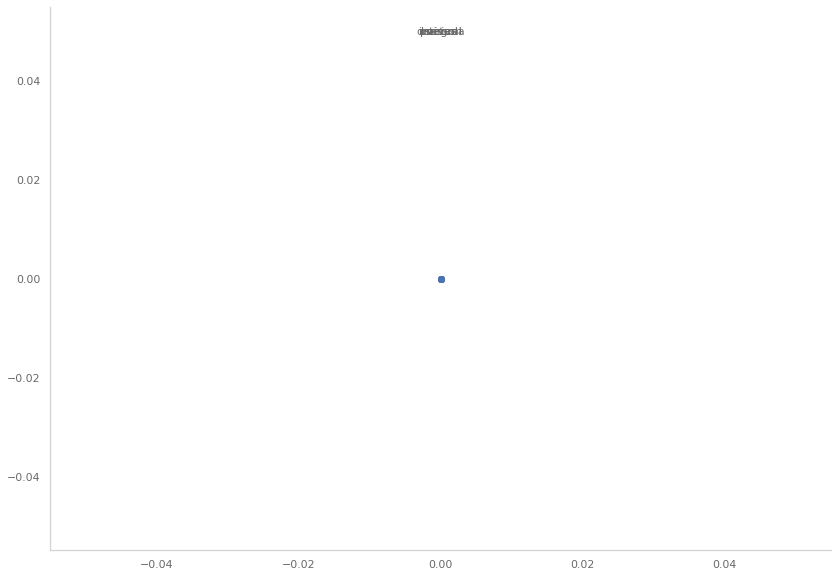

In [19]:
# Examples of word embeddings similarity

words_to_plot = [ 'azul', 'amarelo', 'branco', 'cultura', 'arte', 'educacao', 'musica', 'teatro',
                  'cinema', 'verde', 'rosa', 'integral', 'derivada', 'vetor', 
                  'series', 'poisson']

plt.rcParams['figure.figsize'] = (14, 10)

pca = PCA(n_components=2)
X = pca.fit_transform(get_embeddings(words_to_plot))
plt.scatter(x=X[:,0], y=X[:,1])
 
# Inserts labels to the plot
for i in range(len(words_to_plot)):
    plt.text(X[i, 0], X[i, 1] + 0.05, words_to_plot[i], ha='center', va='center', fontsize = 11)

### Palavras mais próximas à palavra dada

In [ ]:
# Finds words closest to the given word
get_closest_words(get_embedding('amor'), 10)

### Processamento do dataset de tweets

In [ ]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

# Processes tweet dataset

df = pd.read_csv('NoThemeTweets.csv')

df = df[['tweet_text', 'sentiment']]
df['sentiment'] = (df['sentiment'] == 'Positivo').astype(int)

def process_tweet(text):
    txt = unidecode(text).replace('\n' , '').lower() # Normalizes string
    txt = re.sub(r"@\w+", "", txt)
    txt = re.sub(r"\([^()]*\)", "", txt) # Removes everything inside parenthesis
    txt = re.sub(r'\w*\d\w*', ' ', txt).strip() # Remove numbers
    txt = re.sub(r'[^a-zA-Z0-9]', ' ', txt) # Removes all non-alphanumeric characters
    txt = re.sub(r"\s{2,}", ' ', txt).strip() # Removes double or more spaces
    return txt
    
df['tweet_text'] = df['tweet_text'].progress_map(process_tweet)

### Calcula um embedding para tweets usando os embeddings aprendidos do dataset do capes

In [ ]:
def tweet_embedding(text):
    emb = np.zeros(dim)
    
    for word in text.split(' '):
        emb = emb + get_embedding(word)
    return emb / len(text.split(' '))
    
X = np.array([tweet_embedding(txt) for txt in tqdm(df['tweet_text'])])

### Define a variável-resposta

In [ ]:
Y = np.array(df['sentiment'])

### Define o split de treino e teste, e fita um modelo de regressão logística

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression().fit(x_train, y_train, max_iter=1000)

### Resultado

In [ ]:
(model.predict(x_test) == y_test).mean()